# Optics notebook

17.02.2025 -> 11.05.2025 - Dominique Humbert
Initial version for function building.


In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from ows import fouriertransform as mathft
from astropy.io import fits

import numpy as np
from ows import ows
import time

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

SAVE = False

## PSD
Power spectrum density

In [2]:

# Input

dimmat = 256
dxp = 0.00304 # Pupil plane pixel size
r0 = .1
L0 = 27
D = .1
wl = 500e-9 # [m]

# Computing limit values
FoV = 25*asec2rad # arcsec
#Npx = 1000 # image plane pixels qty
#Daf = asec2rad*FoV#/Npx # [rad/px]  (Numerical aperture)
Daf = wl/(2*D) # max
dfp = Daf/wl # [/m] Pupil plane spatial frequency pixel size (Numerical aperture/WL)
dimpsf = 8*wl*np.sqrt((D/r0)**2 + 1)/(Daf*D)   # (min psf size) Matrix size
print("Miminum matrix dimention :",dimpsf)
# dimmat = int(dimpsf)+int((dimpsf %1 !=0)*1)
# dimmat += int((dimmat %2 != 0)*1)

if dimmat < dimpsf:
    print(f"dimmat is too small: {dimmat:d}. It souhld be greater than {dimpsf:.1f}")


PSD = ows.psd(dimmat, dxp, r0, wl)
# plt.close(1)
# plt.figure(1)
# plt.imshow(PSD**(1/8))
# plt.title("Phase spectrum density ^(1/8)")
# plt.colorbar()

Miminum matrix dimention : 22.627416997969522


## Phase screen & PSF

Processing:  10 % done, time elapsed:  0.04405093193054199 s, remaining: ~ 0.39645838737487793 s
Processing:  20 % done, time elapsed:  0.06505179405212402 s, remaining: ~ 0.2602071762084961 s
Processing:  30 % done, time elapsed:  0.08504176139831543 s, remaining: ~ 0.19843077659606934 s
Processing:  40 % done, time elapsed:  0.105224609375 s, remaining: ~ 0.1578369140625 s
Processing:  50 % done, time elapsed:  0.12583208084106445 s, remaining: ~ 0.12583208084106445 s
Processing:  60 % done, time elapsed:  0.146287202835083 s, remaining: ~ 0.09752480189005536 s
Processing:  70 % done, time elapsed:  0.16628742218017578 s, remaining: ~ 0.07126603807721821 s
Processing:  80 % done, time elapsed:  0.18651556968688965 s, remaining: ~ 0.04662889242172241 s
Processing:  90 % done, time elapsed:  0.2063431739807129 s, remaining: ~ 0.022927019331190318 s
0.3068348033416519
Processing time : 208.3454132080078 ms
S:  0.10887068921295627


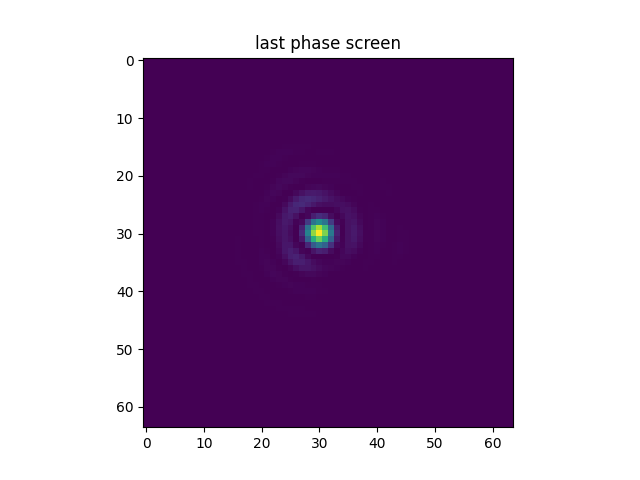

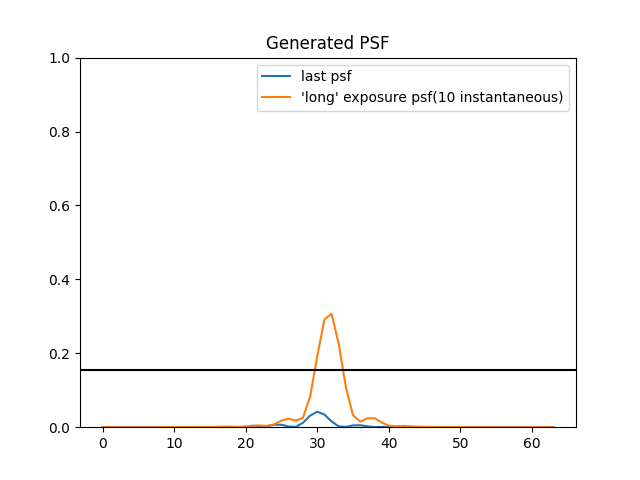

In [4]:
start = time.time()

SEED = None

F = 8e-3 #[m]
N = 8
PD = [dimmat//4,0]
n = 10            # Qty of images
wl = 532e-9 #[m]


# Prepare seeing limited psf for normalization. It could be done inside ows.phase_screen() with the OTF directly but is not in order not to compute it every time
psf_normalization_factor = ows.compute_diffLim_psf(PD, 128, dxp).max() # could also be done with telescope_otf()


psf_stack = np.zeros((PD[0],PD[0]))
before = time.time()
status = 0

for i in range(n):
    [phase_screen, psf, pupil_mask, R] = ows.phase_screen(PSD, dxp, SEED, PUPIL = True, PD = [PD[0], PD[1]])
    [lightfield, DwDx, DwDy] = ows.SHWFS(dimmat, PD, N, F, wl, pupil_mask, R, phase_screen, dxp)
    S = psf[PD[0]//2,PD[0]//2]/psf_normalization_factor
    psf_stack += ows.normalize(psf)*S
    psf = ows.normalize(psf)*S

    lightfield = S*ows.normalize(lightfield)
    # Approximation: normalize the lightfield and scale with the psf strehl ratio.
    # !!! should normalize each "PSFlet" of each lenslet with the diffraciton limited psf of a lenslet. !!! -> more than good enough for now
    
    if SAVE:
        fits.writeto('data/ps_'+str(i)+'.fits', phase_screen[dimmat//2-PD[0]//2:dimmat//2+PD[0]//2,dimmat//2-PD[0]//2:dimmat//2+PD[0]//2], overwrite=True)
        fits.writeto('data/psf_'+str(i)+'.fits', psf, overwrite=True)
        fits.writeto('data/DwDx_'+str(i)+'.fits', DwDx, overwrite=True)
        fits.writeto('data/DwDy_'+str(i)+'.fits', DwDy, overwrite=True)
        fits.writeto('data/lightfield_'+str(i)+'.fits', S*ows.normalize(lightfield), overwrite=True)

    if 100*i//n == status*10:
        now = time.time()
        elapsed = now - before
        if status != 0:
            print('Processing: ',status*10,'% done, time elapsed: ',elapsed,'s, remaining: ~',((elapsed/(i/n))-elapsed),'s')
        status += 1
psf_stack = psf_stack/n
end = time.time()
print(psf_stack.max())

print("Processing time :",
      (end-start) * 10**3, "ms")
print("S: ",S)
plt.close(3)
plt.figure(3)
plt.imshow(psf)
plt.title("last phase screen")
plt.show()

plt.close(4)
plt.figure(4)
plt.plot(psf[32,:])
plt.plot(psf_stack[32,:])
plt.axhline(y=psf_stack.max()/2,c='k')
plt.ylim([0,1])
plt.legend(["last psf",f"'long' exposure psf({n:0} instantaneous)"])
plt.title("Generated PSF")


# Other data that could be displayed

# plt.close(5)
# plt.figure(5)
# plt.subplot(1,3,1)
# plt.imshow(lightfield)
# plt.title("last lightfield")
# plt.subplot(1,3,2)
# plt.imshow(DwDx)
# plt.title("last DwDx")
# plt.subplot(1,3,3)
# plt.imshow(DwDy)
# plt.title("last DwDy")

# plt.close(5)
# plt.figure(5)
# plt.imshow(lightfield)
# plt.colorbar()
# plt.title("Example of instantaneous lightfield")

# plt.close(6)
# plt.figure(6)
# plt.imshow(DwDx)
# plt.title("DwDx associated to the lightfield")
# plt.colorbar()
# plt.close(7)
# plt.figure(7)

# plt.imshow(DwDy)
# plt.colorbar()
# plt.title("DwDy associated to the lightfield")

plt.show()


# Long exposure PSF

0.9772644447273517
0.5002634226571905
S: 0.5002634226571905


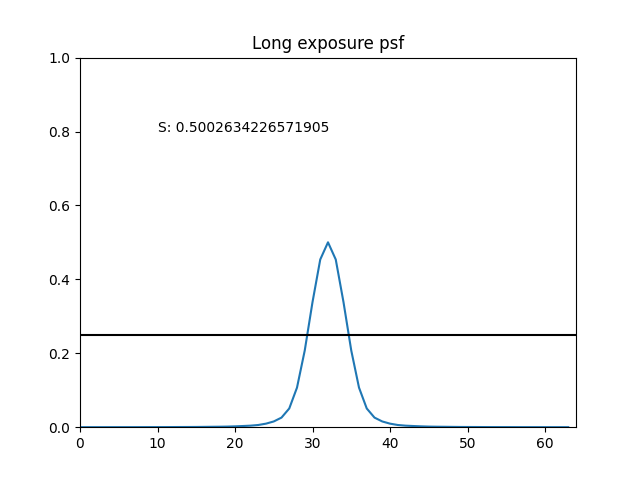

In [12]:
dimmat_psf =64
delta_nu = 2*D/(dimmat_psf*wl)  # Angular frequency sampling
nu_x = np.linspace(-dimmat_psf/2, dimmat_psf/2-1, dimmat_psf) * delta_nu
NU_X, NU_Y = np.meshgrid(nu_x, nu_x)
nu = np.sqrt(NU_X**2 + NU_Y**2)
nu_n = nu * wl / D

otf_tsc = ows.telescope_otf(nu_n)
otf_atm = ows.atmospheric_otf(nu, r0, L0, wl)

otf_sl = otf_atm * otf_tsc

strehl = np.sum(otf_sl) / np.sum(otf_tsc)

padding = 2
otf_sl_pad = np.zeros((padding*dimmat_psf,padding*dimmat_psf))
otf_sl_pad[0:dimmat_psf,0:dimmat_psf] = otf_sl
longpsf = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(otf_sl_pad))))[dimmat_psf-dimmat_psf//2:dimmat_psf+dimmat_psf//2,dimmat_psf-dimmat_psf//2:dimmat_psf+dimmat_psf//2]
print(longpsf.sum())
longpsf = ows.normalize(longpsf)
longpsf = longpsf*strehl

otf_tsc_pad = np.zeros((padding*dimmat_psf,padding*dimmat_psf))
otf_tsc_pad[0:dimmat_psf,0:dimmat_psf] = otf_tsc
idealpsf = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(otf_tsc_pad))))[dimmat_psf-dimmat_psf//2:dimmat_psf+dimmat_psf//2,dimmat_psf-dimmat_psf//2:dimmat_psf+dimmat_psf//2]

idealpsf = ows.normalize(idealpsf)

print(strehl)

plt.close(1)
plt.figure(1)
# plt.subplot(1,2,1)
plt.plot(longpsf[32,:])
plt.axhline(y=longpsf.max()/2,c='k')
plt.title("Long exposure psf")
plt.ylim([0,1])
plt.xlim([0,dimmat_psf])
text = "S: "+str(strehl)
print(text)
plt.text(10,.8,text)
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.imshow(otf_atm)

plt.show()



# fits.writeto('data/longpsf.fits', longpsf, overwrite=True)


# Lenslet array illumination

# SHWFS

## 1. Lenslet illumination mask

Lenslet with coverage $\geq$ 50\% are considered.

## 2. Wavefront slope


1. Focal plane image:
$$U_f= \frac{1}{i\lambda F}\mathcal{F}\{t_p(x,y)\}$$

where $t_p(x,y)$ is the object (the phase screen in this case)


2. Compute the spot centers

$$x_{c,k} = \frac{\sum_{i\in k}\sum_{j\in k} x_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

$$y_{c,k} = \frac{\sum_{i\in k}\sum_{j \in k} y_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

3. Extract the WF slopes

$$ \begin{bmatrix}\partial w /\partial x \\ \partial w/\partial y\end{bmatrix}_k = \begin{bmatrix} \beta_x\\\beta_y \end{bmatrix}_k \approx \frac{1}{L_H}\begin{bmatrix} x_c - x_r\\y_c - y_r \end{bmatrix}_k$$


In [ ]:
from ows import fouriertransform as mathft

### 1. focussing the sub-apetures + aperture centres
F = 8e-3 #[m]
N = 16

[lightfield, DwDx, DyDx] = ows.SHWFS(dimmat, N, F, wl, pupil_mask, R, phase_screen, dxp, lenslet_pad=4)

end = time.time()

print("Processingtime :",
      (end-start) * 10**3, "ms")


lightfield = ows.normalize(lightfield)

plt.close(8)
plt.figure(8)
plt.imshow(lightfield)
plt.title("padded lightfield")
plt.show()

# plt.close(9)
# plt.figure(9)
# plt.subplot(1,2,1)
# plt.imshow(DwDx)
# plt.title("Dw/Dx")
# plt.subplot(1,2,2)
# plt.imshow(DwDy)
# plt.title("Dw/Dy")
# plt.show()

